In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Normalization, Resizing, RandomFlip, RandomRotation, RandomZoom
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from keras.utils import plot_model

In [3]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/Data/"
drive.mount('/content/gdrive')

In [5]:
data = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/Colab Notebooks/Data/")

Found 918 files belonging to 3 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

In [8]:
data = data.map(lambda x,y: (x/255, y))

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
img_shape = (256, 256, 3)
n_classes = 3

In [15]:
dnn_model = Sequential()

imported_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=img_shape,
                   pooling='avg',classes=n_classes,)
for layer in imported_model.layers:
        layer.trainable=False

dnn_model.add(Normalization())
dnn_model.add(Resizing(256, 256))
dnn_model.add(RandomFlip("horizontal"))
dnn_model.add(RandomRotation(factor=0.02))
dnn_model.add(RandomZoom(height_factor=0.2, width_factor=0.2))
dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(n_classes, activation='softmax'))
dnn_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [26]:
history = dnn_model.fit(
  train,
  validation_data=val,
  epochs=20
)

Epoch 1/20
20/20 [==============================] - 122s 6s/step - loss: 0.2897 - accuracy: 0.8922 - val_loss: 0.2849 - val_accuracy: 0.8906
Epoch 2/20
20/20 [==============================] - 86s 4s/step - loss: 0.3045 - accuracy: 0.8828 - val_loss: 0.3266 - val_accuracy: 0.8125
Epoch 3/20
20/20 [==============================] - 84s 4s/step - loss: 0.3332 - accuracy: 0.8703 - val_loss: 0.3480 - val_accuracy: 0.8594
Epoch 4/20
20/20 [==============================] - 83s 4s/step - loss: 0.3365 - accuracy: 0.8562 - val_loss: 0.5282 - val_accuracy: 0.7969
Epoch 5/20
20/20 [==============================] - 85s 4s/step - loss: 0.2760 - accuracy: 0.8969 - val_loss: 0.4174 - val_accuracy: 0.8594
Epoch 6/20
20/20 [==============================] - 124s 6s/step - loss: 0.2642 - accuracy: 0.9016 - val_loss: 0.2728 - val_accuracy: 0.8906
Epoch 7/20
20/20 [==============================] - 87s 4s/step - loss: 0.2583 - accuracy: 0.8984 - val_loss: 0.2853 - val_accuracy: 0.8906
Epoch 8/20
20/20 [

In [27]:
labels = {'HSIL':0,'LSIL':1,'NSIL':2}

In [28]:
def testing(model):
  pre = Precision()
  re = Recall()
  acc = SparseCategoricalAccuracy()
  pred = []
  y_test = []
  for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_test.append(y)
    yhat = np.argmax(model.predict(X), axis=1)
    pred.append(yhat)
    xy=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, xy)

  pred = np.array(pred)
  pred = pred.reshape((pred.size,))
  y_test = np.array(y_test)
  y_test = y_test.reshape((y_test.size,))
  print(accuracy_score(y_test, pred))
  ConfusionMatrixDisplay.from_predictions(y_test, pred)
  tf.keras.utils.plot_model(model,show_shapes=True)
  print(classification_report(y_test, pred, target_names=labels))

1/1 [==============================] - 0s 49ms/step
0.84375
              precision    recall  f1-score   support

        HSIL       0.92      0.55      0.69        44
        LSIL       0.76      0.85      0.81        34
        NSIL       0.85      1.00      0.92        82

    accuracy                           0.84       160
   macro avg       0.85      0.80      0.80       160
weighted avg       0.85      0.84      0.83       160



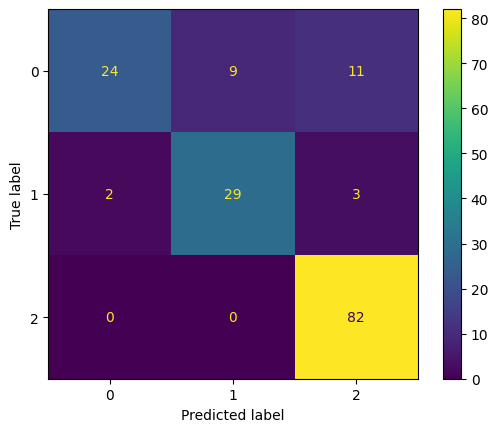

In [29]:
testing(dnn_model)

In [30]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 256, 256, 3)      7         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               1

In [32]:
dnn_model.save(os.path.join("/content/gdrive/MyDrive/Colab Notebooks/models",'vgg_01.h5'))